# ICD–CPT Co-occurrence Analysis
This project analyzes common diagnosis–procedure pairings using Synthea-generated EHR data. We focus on patient encounters to ensure clinical relevance of associations.


In [2]:
import pandas as pd

# Absolute path to CSV files
base_path = "C:/Users/musar/OneDrive/Desktop/Health Project/synthea-master/output/csv/"

patients = pd.read_csv(base_path + "patients.csv")
conditions = pd.read_csv(base_path + "conditions.csv")
procedures = pd.read_csv(base_path + "procedures.csv")
encounters = pd.read_csv(base_path + "encounters.csv")

print("Patients:", patients.shape)
print("Conditions:", conditions.shape)
print("Procedures:", procedures.shape)
print("Encounters:", encounters.shape)

patients.head()


Patients: (572, 28)
Conditions: (20806, 7)
Procedures: (91215, 10)
Encounters: (33701, 15)


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,LAST,...,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,05cdd765-d841-e0ec-d098-03b6d2741936,2022-10-03,NaN,999-82-4287,NaN,NaN,NaN,Daniel959,NaN,Towne435,...,Framingham,Massachusetts,Middlesex County,25017.0,1702,42.320523,-71.480535,7823.05,0.00,194966
1,a523ce08-91c1-bb9a-7b7b-80eba508cdf5,2010-08-21,NaN,999-47-4096,NaN,NaN,NaN,Wilfred787,Diego848,Sanford861,...,Mansfield,Massachusetts,Bristol County,NaN,0,42.012863,-71.185205,35227.49,5612.37,65893
2,143b4aaa-1c3b-31f6-6d97-9c2ca5e0c2b0,2010-05-27,NaN,999-35-6806,NaN,NaN,NaN,Belle514,Kazuko67,Reilly981,...,Boston,Massachusetts,Suffolk County,25025.0,2122,42.361092,-70.997638,53894.48,13165.28,84145
3,84e34eb1-2821-c9b2-db22-35688411fb95,2002-01-18,NaN,999-91-9467,S99987894,X78899244X,Ms.,Ying817,Carylon722,Adams676,...,Quincy,Massachusetts,Norfolk County,25021.0,2169,42.200756,-70.977858,102785.72,70096.53,108929
4,6fa4169b-1eb8-2c16-549b-f9bce4e483a2,2000-10-04,NaN,999-72-5551,S99979922,X71728458X,Mr.,Raymundo71,Luther918,Langworth352,...,Watertown,Massachusetts,Middlesex County,25017.0,2472,42.413859,-71.180673,60802.57,6970.44,55044


## Data Overview

The dataset includes four key tables:

- `patients.csv`: Demographic details
- `conditions.csv`: ICD-10 diagnosis records
- `procedures.csv`: CPT and SNOMED procedure records
- `encounters.csv`: Visit-level information, linking conditions and procedures

Shape of datasets:
- Patients: (572 rows)
- Conditions: (20,806 rows)
- Procedures: (91,215 rows)
- Encounters: (33,701 rows)


In [4]:
# Most common ICD-10 diagnosis codes
conditions['CODE'].value_counts().head(10)


CODE
314529007    4076
73595000     1620
66383009     1557
160903007    1511
160904001     893
422650009     580
444814009     577
423315002     574
741062008     540
18718003      446
Name: count, dtype: int64

In [5]:
conditions[['CODE', 'DESCRIPTION']].drop_duplicates().head(10)


,CODE,DESCRIPTION
0,314529007,Medication review due (situation)
4,195662009,Acute viral pharyngitis (disorder)
7,10509002,Acute bronchitis (disorder)
11,444814009,Viral sinusitis (disorder)
14,43878008,Streptococcal sore throat (disorder)
18,80583007,Severe anxiety (panic) (finding)
21,75498004,Acute bacterial sinusitis (disorder)
23,65363002,Otitis media (disorder)
26,66383009,Gingivitis (disorder)
29,48333001,Burn injury (morphologic abnormality)


## Initial Diagnosis–Procedure Co-occurrence (Patient-Level)

Before applying temporal logic, we grouped condition and procedure codes by patient to examine which codes tend to appear together in a patient's history. This method ignores timing and may link unrelated events.


In [7]:
# Match top ICD codes to their descriptions
conditions[['CODE', 'DESCRIPTION']].drop_duplicates().set_index('CODE').loc[
    conditions['CODE'].value_counts().head(10).index
]


,DESCRIPTION
CODE,
314529007,Medication review due (situation)
73595000,Stress (finding)
66383009,Gingivitis (disorder)
160903007,Full-time employment (finding)
160904001,Part-time employment (finding)
422650009,Social isolation (finding)
444814009,Viral sinusitis (disorder)
423315002,Limited social contact (finding)
741062008,Not in labor force (finding)


## Diagnosis Frequencies by Gender

This table shows how often each diagnosis was recorded for females vs. males. While this is not restricted to single encounters, it reflects all diagnosis records per patient and allows for gender-based health pattern exploration.


In [9]:
# Merge conditions with patient demographics
cond_demo = conditions.merge(patients, left_on='PATIENT', right_on='Id')

# Count diagnosis occurrences by gender
gender_breakdown = cond_demo.groupby(['DESCRIPTION', 'GENDER']).size().unstack().fillna(0)

# View top diagnosis breakdown
gender_breakdown.loc[gender_breakdown.sum(axis=1).sort_values(ascending=False).head(10).index]


GENDER,F,M
DESCRIPTION,,
Medication review due (situation),2132.0,1944.0
Stress (finding),821.0,799.0
Gingivitis (disorder),802.0,755.0
Full-time employment (finding),774.0,737.0
Part-time employment (finding),471.0,422.0
Social isolation (finding),297.0,283.0
Viral sinusitis (disorder),293.0,284.0
Limited social contact (finding),280.0,294.0
Not in labor force (finding),270.0,270.0


## Diagnosis Distribution by Age Group

To explore public health trends across age cohorts, we convert birthdates to age, then bin into:

- 0–18
- 19–35
- 36–50
- 51–65
- 66–80
- 80+

The table below shows how frequently each diagnosis appears across these age groups, using all recorded encounters.


In [11]:
# Convert birthdate to age
from datetime import datetime

today = pd.to_datetime("today")
cond_demo['AGE'] = (today - pd.to_datetime(cond_demo['BIRTHDATE'])).dt.days // 365

# Create age bins
cond_demo['AGE_GROUP'] = pd.cut(
    cond_demo['AGE'],
    bins=[0, 18, 35, 50, 65, 80, 120],
    labels=['0–18', '19–35', '36–50', '51–65', '66–80', '80+']
)

# Count top diagnoses by age group
age_breakdown = cond_demo.groupby(['DESCRIPTION', 'AGE_GROUP'], observed=True).size().unstack().fillna(0)

# View most common diagnoses by age
age_breakdown.loc[age_breakdown.sum(axis=1).sort_values(ascending=False).head(10).index]


AGE_GROUP,0–18,19–35,36–50,51–65,66–80,80+
DESCRIPTION,,,,,,
Medication review due (situation),760.0,417.0,463.0,905.0,726.0,786.0
Stress (finding),1.0,172.0,248.0,430.0,393.0,376.0
Gingivitis (disorder),120.0,196.0,208.0,382.0,329.0,322.0
Full-time employment (finding),2.0,170.0,238.0,417.0,353.0,331.0
Part-time employment (finding),0.0,83.0,127.0,254.0,214.0,215.0
Social isolation (finding),1.0,61.0,74.0,154.0,138.0,152.0
Viral sinusitis (disorder),105.0,120.0,115.0,113.0,77.0,47.0
Limited social contact (finding),0.0,82.0,88.0,128.0,135.0,141.0
Not in labor force (finding),0.0,59.0,80.0,147.0,131.0,123.0


## Note on GroupBy Warning

Earlier versions of pandas defaulted to `observed=False` when grouping by categorical data, which includes unobserved combinations in the output. To future-proof this notebook and remove the warning:

```python
groupby(..., observed=True)


In [13]:
# Join conditions and procedures on patient ID
diag_proc = conditions.merge(procedures, on='PATIENT', suffixes=('_DX', '_PROC'))

# Preview
diag_proc[['DESCRIPTION_DX', 'DESCRIPTION_PROC']].head()


,DESCRIPTION_DX,DESCRIPTION_PROC
0,Medication review due (situation),Medication reconciliation (procedure)
1,Medication review due (situation),Medication reconciliation (procedure)
2,Medication review due (situation),Patient referral for dental care (procedure)
3,Medication review due (situation),Dental consultation and report (procedure)
4,Medication review due (situation),Dental care (regime/therapy)


In [14]:
# Count most frequent diagnosis–procedure pairs
pair_counts = diag_proc.groupby(['DESCRIPTION_DX', 'DESCRIPTION_PROC']).size().reset_index(name='count')

# Sort by count
top_pairs = pair_counts.sort_values(by='count', ascending=False).head(10)
top_pairs


,DESCRIPTION_DX,DESCRIPTION_PROC,count
20444,Medication review due (situation),Depression screening (procedure),176829
20629,Medication review due (situation),Renal dialysis (procedure),137568
20385,Medication review due (situation),Assessment of health and social care needs (pr...,112263
31688,Stress (finding),Depression screening (procedure),80369
20543,Medication review due (situation),Medication reconciliation (procedure),73389
12503,Full-time employment (finding),Depression screening (procedure),73058
13192,Gingivitis (disorder),Depression screening (procedure),69755
31866,Stress (finding),Renal dialysis (procedure),61338
20569,Medication review due (situation),Patient referral for dental care (procedure),60802
13373,Gingivitis (disorder),Renal dialysis (procedure),57914


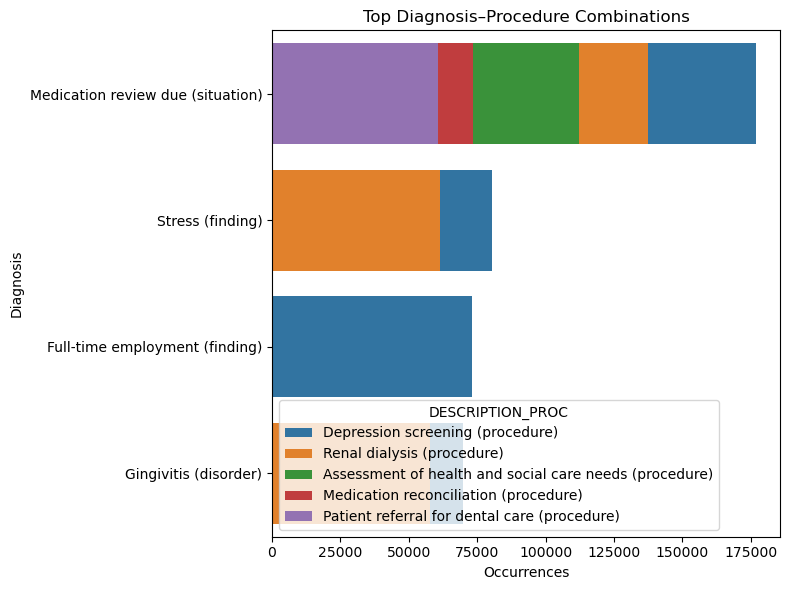

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot as horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=top_pairs, y='DESCRIPTION_DX', x='count', hue='DESCRIPTION_PROC', dodge=False)
plt.title("Top Diagnosis–Procedure Combinations")
plt.xlabel("Occurrences")
plt.ylabel("Diagnosis")
plt.tight_layout()
plt.show()


In [16]:
conditions.columns, procedures.columns


(Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'SYSTEM', 'CODE',
        'DESCRIPTION'],
       dtype='object'),
 Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'SYSTEM', 'CODE',
        'DESCRIPTION', 'BASE_COST', 'REASONCODE', 'REASONDESCRIPTION'],
       dtype='object'))

In [17]:
# Merge conditions and procedures by shared encounter ID
diag_proc_enc = conditions.merge(procedures, on='ENCOUNTER', suffixes=('_DX', '_PROC'))

# Preview
diag_proc_enc[['DESCRIPTION_DX', 'DESCRIPTION_PROC']].head()


,DESCRIPTION_DX,DESCRIPTION_PROC
0,Medication review due (situation),Medication reconciliation (procedure)
1,Medication review due (situation),Medication reconciliation (procedure)
2,Medication review due (situation),Patient referral for dental care (procedure)
3,Acute viral pharyngitis (disorder),Throat culture (procedure)
4,Medication review due (situation),Medication reconciliation (procedure)


In [18]:
print("Encounter-linked rows:", diag_proc_enc.shape[0])


Encounter-linked rows: 85764


In [19]:
# Frequency of diagnosis–procedure pairs within encounters
encounter_pairs = diag_proc_enc.groupby(['DESCRIPTION_DX', 'DESCRIPTION_PROC']).size().reset_index(name='count')
encounter_pairs = encounter_pairs.sort_values(by='count', ascending=False).head(15)
encounter_pairs


,DESCRIPTION_DX,DESCRIPTION_PROC,count
820,Medication review due (situation),Depression screening (procedure),4140
813,Medication review due (situation),Assessment of health and social care needs (pr...,2545
529,Gingivitis (disorder),Depression screening (procedure),2214
1245,Stress (finding),Depression screening (procedure),2182
490,Full-time employment (finding),Depression screening (procedure),1970
825,Medication review due (situation),Medication reconciliation (procedure),1694
814,Medication review due (situation),Assessment of substance use (procedure),1604
534,Gingivitis (disorder),Patient referral for dental care (procedure),1553
826,Medication review due (situation),Patient referral for dental care (procedure),1534
1235,Stress (finding),Assessment of health and social care needs (pr...,1399


### Key Insights from EHR Analysis (572 Patients)

- **Top diagnoses**: "Medication review due", "Stress", and "Gingivitis"
- **Demographic patterns**:
  - Diagnoses are gender-balanced
  - Stress and gingivitis peak in 36–65 age group
- **Most common procedures**: "Depression screening", "Social care assessment", "Medication reconciliation"
- **Top diagnosis–procedure pairs (same encounter)**:
  - "Medication review due" → "Depression screening" (4,140 times)
  - "Gingivitis" → "Depression screening" and "Dental care referral"
  - "Stress" → "Depression screening", "Substance use assessment"
- **Clinical implication**: Preventive and behavioral health services frequently co-occur with general and dental care—suggesting an integrated care model.



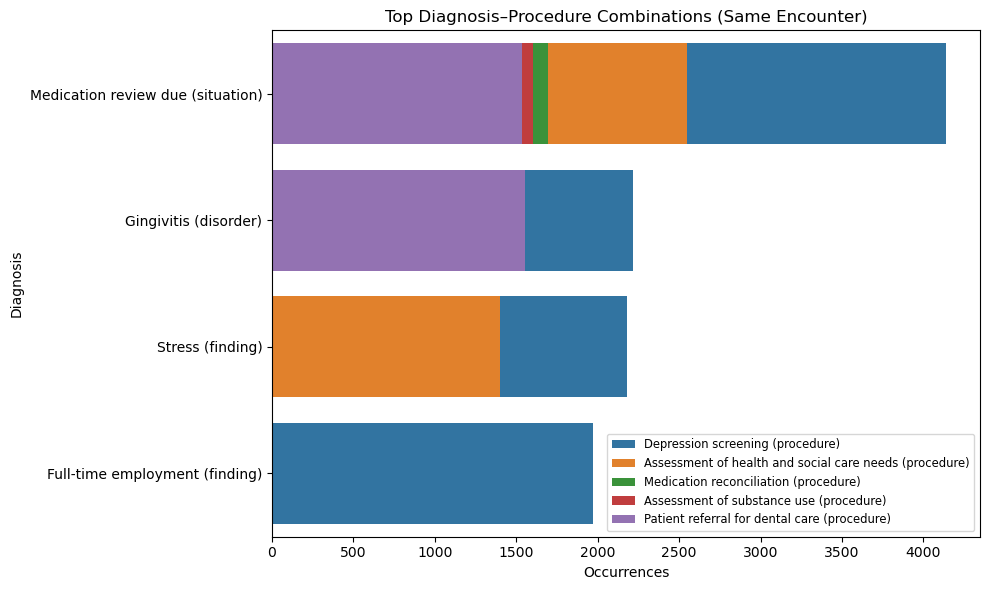

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 10 encounter-based diagnosis–procedure pairs
plt.figure(figsize=(10, 6))
sns.barplot(
    data=encounter_pairs.head(10),
    y='DESCRIPTION_DX',
    x='count',
    hue='DESCRIPTION_PROC',
    dodge=False
)

plt.title("Top Diagnosis–Procedure Combinations (Same Encounter)")
plt.xlabel("Occurrences")
plt.ylabel("Diagnosis")
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()


## Summary of Findings

- Most common diagnoses included: **Medication review due**, **Stress**, and **Gingivitis**
- Most frequent procedures: **Depression screening**, **Social care assessment**, **Medication reconciliation**
- Top ICD–CPT pairs (same encounter):
    - "Medication review due" → "Depression screening" (4,140 times)
    - "Gingivitis" → "Dental referral" and "Social care assessment"
- Demographic trends:
    - Stress and gingivitis peak in adults 36–65
    - Diagnosis frequencies are relatively gender-balanced

This analysis simulates core responsibilities in public health and EHR data analytics, including data wrangling, encounter-level merging, and clinical pattern detection.
